## This code is to show the difference performence between different power limit of the GPU

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from DataCenter import DataCenter
from PV import PV
import os

### read data

In [36]:
current_path = Path.cwd()
print(current_path)
# find the path of the parent directory
parent_path = current_path.parent
print(parent_path)
# find the path of the data folder
pvdata_path = parent_path / 'PVdata'
print(pvdata_path)
# PV1 file path
PV1_path = pvdata_path / 'PV1'
PV1_info = PV1_path / 'Info.csv'
PV1_hourlydata = PV1_path / 'Hourly_Data.csv'
PV1_irradiance = PV1_path / 'Irradiance.csv'
print(PV1_info, PV1_hourlydata, PV1_irradiance)

datapath = parent_path / 'Data/alexnet/cifar100'
print('The data path is', datapath)

/home/yj/FinalThesis/GreenAI/PVWatts/code
/home/yj/FinalThesis/GreenAI/PVWatts
/home/yj/FinalThesis/GreenAI/PVWatts/PVdata
/home/yj/FinalThesis/GreenAI/PVWatts/PVdata/PV1/Info.csv /home/yj/FinalThesis/GreenAI/PVWatts/PVdata/PV1/Hourly_Data.csv /home/yj/FinalThesis/GreenAI/PVWatts/PVdata/PV1/Irradiance.csv
The data path is /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/cifar100


In [37]:
pv1info = pd.read_csv(PV1_info)
pv1hourlydata = pd.read_csv(PV1_hourlydata)
pv1irradiance = pd.read_csv(PV1_irradiance)
# change the first column name of pv1info to Data
pv1info = pv1info.rename(columns={'PVWatts Hourly PV Performance Data': 'Data'})
print(pv1info.head())
print('*'*50)
print(pv1hourlydata.head())
print('*'*50)
print(pv1irradiance.head())

                 Data                  Value
0  Requested Location                  turin
1            Location  TORINO-CASELLE, ITALY
2       Latitude (DD)                  45.18
3      Longitude (DD)                   7.65
4       Elevation (m)                    282
**************************************************
   Month  Day  Hour  Beam Irradiance (W/m2)  Diffuse Irradiance (W/m2)  \
0      1    1     0                       0                          0   
1      1    1     1                       0                          0   
2      1    1     2                       0                          0   
3      1    1     3                       0                          0   
4      1    1     4                       0                          0   

   Ambient Temperature (C)  Wind Speed (m/s)  Albedo  \
0                     -1.4               0.0     0.2   
1                     -1.8               0.0     0.2   
2                     -2.4               0.0     0.2   
3         

In [38]:
# pv1hourlydata
pv1hourlydata 

,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,-1.4,0.0,0.2,0.0,-1.4,0.0,0.0
1,1,1,1,0,0,-1.8,0.0,0.2,0.0,-1.8,0.0,0.0
2,1,1,2,0,0,-2.4,0.0,0.2,0.0,-2.4,0.0,0.0
3,1,1,3,0,0,-3.2,0.0,0.2,0.0,-3.2,0.0,0.0
4,1,1,4,0,0,-3.5,0.0,0.2,0.0,-3.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,0,0,1.5,0.0,0.2,0.0,1.5,0.0,0.0
8756,12,31,20,0,0,1.3,0.0,0.2,0.0,1.3,0.0,0.0
8757,12,31,21,0,0,1.2,0.0,0.2,0.0,1.2,0.0,0.0
8758,12,31,22,0,0,0.9,0.0,0.2,0.0,0.9,0.0,0.0


### create PV1 model

In [39]:
pv1info

,Data,Value
0,Requested Location,turin
1,Location,"TORINO-CASELLE, ITALY"
2,Latitude (DD),45.18
3,Longitude (DD),7.65
4,Elevation (m),282
5,DC System Size (kW),0.2
6,Module Type,Standard
7,Array Type,2-Axis Tracking
8,Array Tilt (deg),0
9,Array Azimuth (deg),180


In [40]:
'''retrive the data from the pv1info file to create the PV1 object'''
# find out the value in the column Value corresponding to the row with the column PVWatts Hourly PV Performance Data value is Location
pv1_location = pv1info.loc[pv1info['Data'] == 'Location']['Value'].values[0].split(',')[0]
# latitude, change the valude to float
pv1_latitude = float(pv1info.loc[pv1info['Data'] == 'Latitude (DD)']['Value'].values[0])
# longitude, change the valude to float
pv1_longitude = float(pv1info.loc[pv1info['Data'] == 'Longitude (DD)']['Value'].values[0])
# elevation, change the valude to float
pv1_elevation = float(pv1info.loc[pv1info['Data'] == 'Elevation (m)']['Value'].values[0])
# DC system size, change the valude to float, the unit is kW
pv1_dc_size = float(pv1info.loc[pv1info['Data'] == 'DC System Size (kW)']['Value'].values[0])
# Module Type
pv1_module_type = pv1info.loc[pv1info['Data'] == 'Module Type']['Value'].values[0]
# Array Type
pv1_array_type = pv1info.loc[pv1info['Data'] == 'Array Type']['Value'].values[0]
# Array Tilt, change the valude to float
pv1_array_tilt = float(pv1info.loc[pv1info['Data'] == 'Array Tilt (deg)']['Value'].values[0])
# array azimuth, change the valude to float
pv1_array_azimuth = float(pv1info.loc[pv1info['Data'] == 'Array Azimuth (deg)']['Value'].values[0])
# system losses, change the valude to float
pv1_system_losses = float(pv1info.loc[pv1info['Data'] == 'System Losses (%)']['Value'].values[0])
# dc to ac ratio, change the valude to float
pv1_dcac_ratio = float(pv1info.loc[pv1info['Data'] == 'DC to AC Size Ratio']['Value'].values[0])
# inverter efficieny, change the valude to float
pv1_inverter_efficiency = float(pv1info.loc[pv1info['Data'] == 'Inverter Efficiency (%)']['Value'].values[0])
# ground coverage ratio, change the valude to float
pv1_ground_coverage_ratio = float(pv1info.loc[pv1info['Data'] == 'Ground Coverage Ratio']['Value'].values[0])
# albedo, if the value is a number, then change the valude to float, otherwise, keep it as string
if pv1info.loc[pv1info['Data'] == 'Albedo']['Value'].values[0].replace('.', '', 1).isdigit():
    pv1_albedo = float(pv1info.loc[pv1info['Data'] == 'Albedo']['Value'].values[0])
else:
    pv1_albedo = pv1info.loc[pv1info['Data'] == 'Albedo']['Value'].values[0]
# Bifacial
pv1_bifacial = pv1info.loc[pv1info['Data'] == 'Bifacial']['Value'].values[0]


print(f'The location of PV1 is: {pv1_location}', '\n', f'The latitude of PV1 is: {pv1_latitude}', '\n', f'The longitude of PV1 is: {pv1_longitude}', '\n',
      f'The elevation of PV1 is: {pv1_elevation}', '\n', f'The DC system size of PV1 is: {pv1_dc_size}kW', '\n',
      f'The module type of PV1 is: {pv1_module_type}', '\n', f'The array type of PV1 is: {pv1_array_type}', '\n',
      f'The array tilt of PV1 is: {pv1_array_tilt}degree', '\n', f'The array azimuth of PV1 is: {pv1_array_azimuth}degree', '\n',
      f'The system losses of PV1 is: {pv1_system_losses}%', '\n', f'The DC to AC ratio of PV1 is: {pv1_dcac_ratio}', '\n',
      f'The inverter efficiency of PV1 is: {pv1_inverter_efficiency}%', '\n', f'The ground coverage ratio of PV1 is: {pv1_ground_coverage_ratio}', '\n'
      f'The albedo of PV1 is: {pv1_albedo}', '\n', f'The bifacial of PV1 is: {pv1_bifacial}')



The location of PV1 is: TORINO-CASELLE 
 The latitude of PV1 is: 45.18 
 The longitude of PV1 is: 7.65 
 The elevation of PV1 is: 282.0 
 The DC system size of PV1 is: 0.2kW 
 The module type of PV1 is: Standard 
 The array type of PV1 is: 2-Axis Tracking 
 The array tilt of PV1 is: 0.0degree 
 The array azimuth of PV1 is: 180.0degree 
 The system losses of PV1 is: 14.08% 
 The DC to AC ratio of PV1 is: 1.2 
 The inverter efficiency of PV1 is: 96.0% 
 The ground coverage ratio of PV1 is: nan 
The albedo of PV1 is: From weather file 
 The bifacial of PV1 is: No (0)


In [41]:
# create PV1 object
pv1 = PV(pv1_location, pv1_latitude, pv1_longitude, pv1_elevation, pv1_dc_size, pv1_module_type, pv1_array_type, pv1_array_tilt, pv1_array_azimuth, pv1_system_losses, pv1_dcac_ratio, pv1_inverter_efficiency, pv1_ground_coverage_ratio, pv1_albedo, pv1_bifacial)
df_hour = pv1.get_hourly_data(pv1hourlydata)
df_hour

,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,-1.4,0.0,0.2,0.0,-1.4,0.0,0.0
1,1,1,1,0,0,-1.8,0.0,0.2,0.0,-1.8,0.0,0.0
2,1,1,2,0,0,-2.4,0.0,0.2,0.0,-2.4,0.0,0.0
3,1,1,3,0,0,-3.2,0.0,0.2,0.0,-3.2,0.0,0.0
4,1,1,4,0,0,-3.5,0.0,0.2,0.0,-3.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,0,0,1.5,0.0,0.2,0.0,1.5,0.0,0.0
8756,12,31,20,0,0,1.3,0.0,0.2,0.0,1.3,0.0,0.0
8757,12,31,21,0,0,1.2,0.0,0.2,0.0,1.2,0.0,0.0
8758,12,31,22,0,0,0.9,0.0,0.2,0.0,0.9,0.0,0.0


In [42]:
# get all the value of AC System Output (W)
ac_output = df_hour['AC System Output (W)'].values
print(ac_output.shape)

(8760,)


In [43]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from d2l import torch as d2l
import numpy as np
import pandas as pd
from ptflops import get_model_complexity_info
from pathlib import Path
import subprocess
import os

In [44]:
# show the ac_output first 24 values
print(ac_output[:24])

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.    36.183
 58.336 75.567 79.805 74.329 59.59  35.204  9.893  0.     0.     0.
  0.     0.     0.     0.   ]


### set model

In [45]:
batch_size = [128]
epochs = [50]
rounds = 1

In [46]:
'''find the Model path'''
# find the current path
current_path = os.getcwd()
print('The current path is:', current_path)

# find the parent path
parent_path = Path(current_path).parent
print('The parent path is:', parent_path)

# find the data path
data_path = parent_path / 'Data/alexnet'
print('The data path is:', data_path)
if not data_path.exists():
    data_path.mkdir(parents=True)
    print('The data path is created:', data_path)
else:
    print('The data path already exists:', data_path)   

The current path is: /home/yj/FinalThesis/GreenAI/PVWatts/code
The parent path is: /home/yj/FinalThesis/GreenAI/PVWatts
The data path is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet
The data path already exists: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet


In [47]:
def alexnet(img_channel, num_labels):
    net = nn.Sequential(
        # 这里使用一个11*11的更大窗口来捕捉对象。
        # 同时，步幅为4，以减少输出的高度和宽度。
        # 另外，输出通道的数目远大于LeNet
        nn.Conv2d(img_channel, 64, kernel_size=11, stride=4, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
        nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 使用三个连续的卷积层和较小的卷积窗口。
        # 除了最后的卷积层，输出通道的数量进一步增加。
        # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
        nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.AdaptiveAvgPool2d((6, 6)),   # 使用全局平均池化对每个通道中所有元素求平均并直接将结果传递到全连接层
        nn.Flatten(),
        # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
        nn.Linear(256 * 6 * 6, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
        nn.Linear(4096, num_labels))
    return net

In [48]:
# print the model structure
net = alexnet(1, 10)    
# print(net)
# print each layer
layer_name = []
for layer in net:
    name = layer.__class__.__name__
    layer_name.append(name)
# find the unique layer name, and fix the order
layer_name = sorted(list(set(layer_name)))
print('The layer name is:', layer_name)
# the number of layers, which contains ['AdaptiveAvgPool2d', 'Conv2d', 'Dropout', 'Flatten', 'Linear', 'MaxPool2d', 'ReLU']
num_layers = len(layer_name) 
print('The number of layers is:', num_layers)

The layer name is: ['AdaptiveAvgPool2d', 'Conv2d', 'Dropout', 'Flatten', 'Linear', 'MaxPool2d', 'ReLU']
The number of layers is: 7


In [49]:
# CIFAR100中的图像通道数为3，类别数为100
alexnet_c = alexnet(3, 100)

In [50]:
# cifar100
with torch.cuda.device(0):
    macs_c, params_c = get_model_complexity_info(alexnet_c, (3, 224, 224), as_strings=True,
                                            print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs_c))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params_c))

Sequential(
  57.41 M, 100.000% Params, 711.87 MMac, 99.877% MACs, 
  (0): Conv2d(23.3 k, 0.041% Params, 70.47 MMac, 9.887% MACs, 3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 193.6 KMac, 0.027% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 193.6 KMac, 0.027% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(307.39 k, 0.535% Params, 224.09 MMac, 31.440% MACs, 64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(0, 0.000% Params, 139.97 KMac, 0.020% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 139.97 KMac, 0.020% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(663.94 k, 1.156% Params, 112.21 MMac, 15.742% MACs, 192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 64.9 KMac, 0.009% MACs, )
  (8): Conv2d(884.99 k, 1.541% Params, 149.56 MMac, 20.984% MACs, 384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): R

In [51]:
X_c = torch.randn(size=(1, 3, 224, 224), dtype=torch.float32) # cifar100

for layer in alexnet_c:
    X_c=layer(X_c)
    print(layer.__class__.__name__,'output shape:\t',X_c.shape)

Conv2d output shape:	 torch.Size([1, 64, 55, 55])
ReLU output shape:	 torch.Size([1, 64, 55, 55])
MaxPool2d output shape:	 torch.Size([1, 64, 27, 27])
Conv2d output shape:	 torch.Size([1, 192, 27, 27])
ReLU output shape:	 torch.Size([1, 192, 27, 27])
MaxPool2d output shape:	 torch.Size([1, 192, 13, 13])
Conv2d output shape:	 torch.Size([1, 384, 13, 13])
ReLU output shape:	 torch.Size([1, 384, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
MaxPool2d output shape:	 torch.Size([1, 256, 6, 6])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 256, 6, 6])
Flatten output shape:	 torch.Size([1, 9216])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:

In [52]:
# load the data
# fashion mnist
def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_utils`"""
    return 4

def load_data_cifar100(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_utils`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    # import the cifar100 dataset
    cifar_train = torchvision.datasets.CIFAR100(
        root="../data", train=True, transform=trans, download=True)
    cifar_test = torchvision.datasets.CIFAR100(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True,
                                        num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False,
                                        num_workers=get_dataloader_workers()))

In [53]:
def train_func(net, train_iter, test_iter, num_layers, num_epochs, lr, device):
    def init_weights(m): # 初始化权重
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    # create a ndarray to store each layer's total running time of each epoch
    Layers_time = np.zeros((num_layers, num_epochs)) # each row is a layer, each column is an epoch
    Train_part_time = np.zeros((4, num_epochs)) # store the time to device, forward and backward time, and test time of each epoch
    Train_time = np.zeros(num_epochs) # store the total training time of each epoch
    Train_acc = np.zeros(num_epochs) # store the training accuracy of each epoch
    Test_acc = np.zeros(num_epochs) # store the test accuracy of each epoch
    Epoch_time = np.zeros(num_epochs) # store the total time of each epoch
    Epoch_energy = np.zeros((num_epochs,1), dtype='object') # store the total energy of each epoch
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    timer = d2l.Timer()
    train_timer = d2l.Timer()
    ttd_timer = d2l.Timer()
    forward_timer = d2l.Timer()
    backward_timer = d2l.Timer()
    layer_timer = d2l.Timer()
    test_timer = d2l.Timer()
    # start training
    for epoch in range(num_epochs):
        print('The epoch is:', epoch+1)
        timer.start()
        net.train()
        train_epoch, ttd_epoch, forward_epoch, backward_epoch, testtime_epoch= 0.0, 0.0, 0.0, 0.0, 0.0
        layer_epoch = np.zeros((num_layers, 1)) # store the total running time of each layer in one epoch
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples   
        # start the nvidia-smi command
        with open('gpu_power_usage.csv', 'w') as file:
            # Start the nvidia-smi command
            nvidia_smi_process = subprocess.Popen(
                ["nvidia-smi", "--query-gpu=power.draw", "--format=csv", "--loop-ms=1000"],
                stdout=file,  # Redirect the output directly to the file
                stderr=subprocess.PIPE,
                text=True)
        train_timer.start()
        for i, (X, y) in enumerate(train_iter):
            print('The batch is:', i+1)
            optimizer.zero_grad()
            # to device
            torch.cuda.synchronize()  # 等待数据传输完成
            ttd_timer.start()
            X, y = X.to(device), y.to(device)
            ttd_epoch += ttd_timer.stop()
            # forward
            torch.cuda.synchronize()  # 等待数据传输完成
            forward_timer.start()
            y_hat = X
            for layer in net:
                name = layer.__class__.__name__ # 获取层的名字
                layer_index = layer_name.index(name)
                layer_timer.start()
                y_hat = layer(y_hat)
                torch.cuda.synchronize()  # 等待数据传输完成
                layer_epoch[layer_index] += layer_timer.stop()
            forward_epoch += forward_timer.stop()
            # loss
            l = loss_fn(y_hat, y)
            # backward
            torch.cuda.synchronize()  # 等待数据传输完成
            backward_timer.start()
            l.backward()
            backward_epoch += backward_timer.stop()
            # optimize
            torch.cuda.synchronize()  # 等待数据传输完成
            optimizer.step()
            torch.cuda.synchronize()  # 等待数据传输完成
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_acc = metric[1] / metric[2]
        train_epoch = train_timer.stop()
        test_timer.start()
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        testtime_epoch = test_timer.stop()
        print(f'train acc {train_acc:.3f}, test acc {test_acc:.3f}')
        print('epoch %d, time %f sec' % (epoch+1, timer.sum()))
        # store the time and acc data
        Epoch_time[epoch] = timer.stop()
        print(f'The total time of the {epoch} is:', Epoch_time[epoch])
        Layers_time[:, epoch] = layer_epoch.flatten()
        Train_part_time[:, epoch] = ttd_epoch, forward_epoch, backward_epoch, testtime_epoch
        Train_time[epoch] = train_epoch
        Train_acc[epoch] = train_acc
        Test_acc[epoch] = test_acc
        # stop the nvidia-smi command
        nvidia_smi_process.terminate()
        # calculate the energy consumption of each epoch
        GPU_df = pd.read_csv('gpu_power_usage.csv')
        for row in range(len(GPU_df)):
            GPU_df.iloc[row,0] = GPU_df.iloc[row,0].replace(' W','')
        Consumption_df = GPU_df.astype(float)  
        EnergyDatai = Consumption_df.iloc[:,0].values # 将数据转换为numpy数组
        # store the energy data
        Epoch_energy[epoch,0] = EnergyDatai
    return Layers_time, Train_part_time, Train_time, Train_acc, Test_acc, Epoch_time, Epoch_energy

In [54]:
def train_model_c(main_folder, batch_size, num_epochs, round, lr, device):
    print(f'The epoch is set: {num_epochs}, batch is set: {batch_size}, is in {round+1}th running')
    # create the folder to store the data
    epoch_batch_folder = main_folder/f'E{num_epochs}_B{batch_size}_R{round}'
    # 判断文件是否存在
    if epoch_batch_folder.exists():
        print("文件存在。")
        pass
    else:
        os.makedirs(epoch_batch_folder)
        print("文件不存在，已创建。")
        print("文件创建于：", epoch_batch_folder)
        train_iter, test_iter = load_data_cifar100(batch_size, resize=224)
        # show the shape of the data
        list_of_i = []
        for i, (X, y) in enumerate(train_iter):
            if i < 3:
                print('the shape of the', i, 'batch of the train_iter is:', X.shape)
            else:
                pass
            list_of_i.append(i)
        print(f'The number of batches is: {np.array(list_of_i).shape}')
        Layers_time, Train_part_time, Train_time, Train_acc, Test_acc, \
            Epoch_time, Epoch_energy = train_func(alexnet_c, train_iter, test_iter, num_layers, num_epochs, lr, device)
        # save the data
        np.save(epoch_batch_folder/'Layers_time.npy', Layers_time)
        np.save(epoch_batch_folder/'Train_part_time.npy', Train_part_time)
        np.save(epoch_batch_folder/'Train_time.npy', Train_time)
        np.save(epoch_batch_folder/'Train_acc.npy', Train_acc)
        np.save(epoch_batch_folder/'Test_acc.npy', Test_acc)
        np.save(epoch_batch_folder/'Epoch_time.npy', Epoch_time)
        np.save(epoch_batch_folder/'Epoch_energy.npy', Epoch_energy)

In [55]:
lr = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The device is:', device)

The device is: cuda


#### original max power capacity

In [22]:
# create the folder to store the data
main_folder = data_path/'cifar100'
print('The folder is:', main_folder)
# find out that if the folder exists in the data path
# 判断文件是否存在
if main_folder.exists():
    print("文件存在。")
else:
    os.makedirs(main_folder)
    print("文件不存在，已创建。")
    print("文件创建于：", main_folder)
for epoch in epochs:
    for batch in batch_size:
        for round in range(rounds):
            train_model_c(main_folder, batch, epoch, round, lr, device)

The folder is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/cifar100
文件存在。
The epoch is set: 50, batch is set: 128, is in 1th running
文件不存在，已创建。
文件创建于： /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/cifar100/E50_B128_R0


100.0%


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified
the shape of the 0 batch of the train_iter is: torch.Size([128, 3, 224, 224])
the shape of the 1 batch of the train_iter is: torch.Size([128, 3, 224, 224])
the shape of the 2 batch of the train_iter is: torch.Size([128, 3, 224, 224])
The number of batches is: (391,)
training on cuda
The epoch is: 1
The batch is: 1
The batch is: 2
The batch is: 3
The batch is: 4
The batch is: 5
The batch is: 6
The batch is: 7
The batch is: 8
The batch is: 9
The batch is: 10
The batch is: 11
The batch is: 12
The batch is: 13
The batch is: 14
The batch is: 15
The batch is: 16
The batch is: 17
The batch is: 18
The batch is: 19
The batch is: 20
The batch is: 21
The batch is: 22
The batch is: 23
The batch is: 24
The batch is: 25
The batch is: 26
The batch is: 27
The batch is: 28
The batch is: 29
The batch is: 30
The batch is: 31
The batch is: 32
The batch is: 33
The batch is: 34
The batch is: 35
The batch is: 36
The b

#### analysis the data

In [14]:
# read the data
fullpowerdata = datapath / 'E50_B128_R0'
print('The full power data path is:', fullpowerdata)

# show the files in the folder
files = os.listdir(fullpowerdata)
print('The files in the folder are:', files)

The full power data path is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/cifar100/E50_B128_R0
The files in the folder are: ['Layers_time.npy', 'Train_part_time.npy', 'Epoch_time.npy', 'Train_acc.npy', 'Epoch_energy.npy', 'Train_time.npy', 'Test_acc.npy']


In [15]:
# load the data
Layers_time = np.load(fullpowerdata/'Layers_time.npy', allow_pickle=True)
Train_part_time = np.load(fullpowerdata/'Train_part_time.npy', allow_pickle=True)
Train_time = np.load(fullpowerdata/'Train_time.npy', allow_pickle=True)
Train_acc = np.load(fullpowerdata/'Train_acc.npy', allow_pickle=True)
Test_acc = np.load(fullpowerdata/'Test_acc.npy', allow_pickle=True)
Epoch_time = np.load(fullpowerdata/'Epoch_time.npy', allow_pickle=True)
Epoch_energy = np.load(fullpowerdata/'Epoch_energy.npy', allow_pickle=True)

In [56]:
# analysis the Epoch_energy data
# create a ndarray to store the energy data, first column is the number of the number that has been recorded, the second solumn is the sum of each epoch, third column is the average of each epoch
Energy_data = np.zeros((Epoch_energy.shape[0], 3))
for i in range(Epoch_energy.shape[0]):
    energyrow = Epoch_energy[i, 0]
    lengthrow = len(energyrow)
    # print(f'The energy data of the {i}th epoch running time is {lengthrow} second, and the recorded data is {energyrow}')
    avgenergy = np.mean(energyrow)
    totalenergy = np.sum(energyrow)
    Energy_data[i, 0] = lengthrow
    Energy_data[i, 1] = totalenergy
    Energy_data[i, 2] = avgenergy
# print('The energy data is:', Energy_data)

# print the Test_acc
print('The Test_acc shape is:', Test_acc.shape)
# print('The Epoch_time is:', Epoch_time)

The Test_acc shape is: (50,)
The Epoch_time is: [40.69633937 40.36413527 40.66256356 40.62509823 40.67436838 40.77355599
 40.65306759 40.84909534 40.83144712 40.81254935 40.82081509 40.79023027
 40.84747553 40.87148595 40.87150216 40.81359887 40.84998918 40.93529224
 40.830791   40.8549974  40.87871122 40.98985672 40.88553619 40.95397186
 40.9765687  40.98738384 40.98499846 40.89069104 40.93154573 40.9657259
 40.98762727 40.95690393 41.01195264 40.99966455 40.99253988 41.02096224
 41.04319429 40.97653294 40.95803022 40.9889195  41.03595972 40.8966372
 40.99913263 40.9335525  40.95911312 40.92635012 40.93976402 40.9545176
 40.99705148 40.9956181 ]


In [29]:
# draw the Test_acc and avg energy consumption, which is the third row of the Energy_data
# create a avgenergy_acc ndarray to store the average energy consumption and Test_acc
avgenergy_acc = np.zeros((Test_acc.shape[0], 2))
avgenergy_acc[:, 0] = Test_acc
avgenergy_acc[:, 1] = Energy_data[:, 2]
# print('The avgenergy_acc is:', avgenergy_acc)

totalenergy_acc = np.zeros((Test_acc.shape[0], 2))
totalenergy_acc[:, 0] = Test_acc
totalenergy_acc[:, 1] = Energy_data[:, 1]

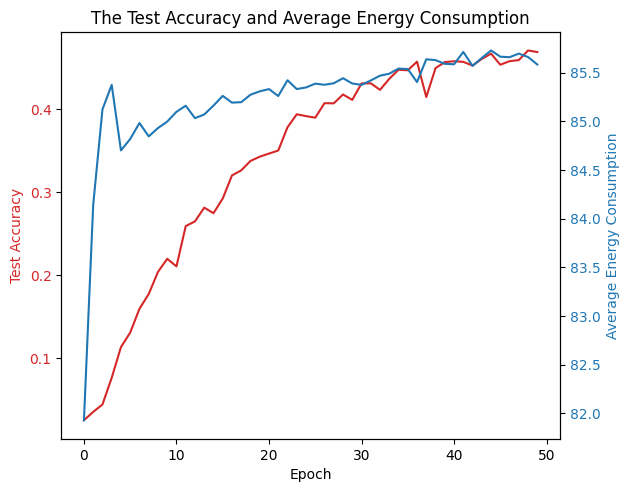

In [32]:
# draw the plot of the avgenergy_acc, the y axis is the Test_acc, the x axis is the average energy consumption, the right axis is the epoch
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.plot(avgenergy_acc[:, 0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Energy Consumption', color=color)
ax2.plot(avgenergy_acc[:, 1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('The Test Accuracy and Average Energy Consumption')
plt.show()

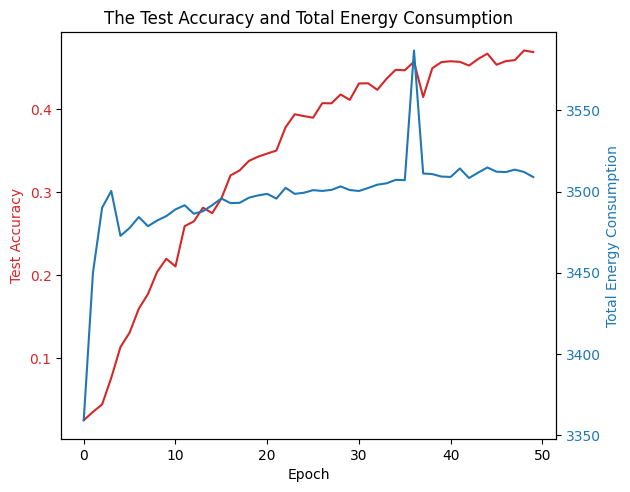

In [33]:
# draw the plot of the totalenergy_acc, the y axis is the Test_acc, the x axis is the total energy consumption, the right axis is the epoch
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.plot(totalenergy_acc[:, 0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Energy Consumption', color=color)
ax2.plot(totalenergy_acc[:, 1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('The Test Accuracy and Total Energy Consumption')
plt.show()

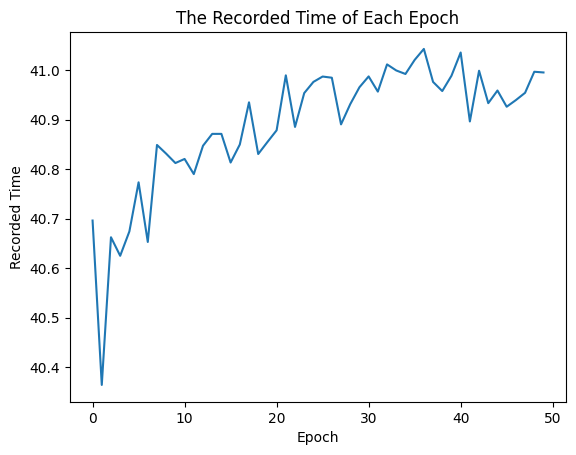

In [57]:
# plot the epoch and the recorded time, the y axis is the recorded time, the x axis is the epoch
fig, ax = plt.subplots()
ax.plot(Epoch_time)
ax.set(xlabel='Epoch', ylabel='Recorded Time',
       title='The Recorded Time of Each Epoch') 
plt.show()

#### each time slot will run 2 minutes, only on pv available